In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import PathLineSentences, LineSentence, Word2Vec
from pathlib import Path
import networkx as nx
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
%matplotlib inline

In [6]:
import sys
sys.path.append("/Users/doc019/Code/stellar-evaluation-plugins")
from utils.epgm import EPGM

ModuleNotFoundError: No module named 'utils'

**Load random walks from output files**

The word2vec model requires sentences of strings, so we convert node number to a string.

In [20]:
rw_location = Path("/Users/pei025/Desktop/spark-apps/runs/karate.path-1517374424")

In [33]:
random_walks_int = np.concatenate([
    np.loadtxt(f.open(), delimiter='\t', dtype=int)
    for f in rw_location.glob("part-*")
    if f.stat().st_size > 0
])
random_walks_str = [list(map(str, v)) for v in random_walks_int]

In [36]:
random_walks_int.shape

(3400, 101)

Calculate empirical transition probabilities

In [62]:
random_walks_int[random_walks_int[:, 0] == 1]

array([[ 1, 14,  3, ..., 25, 28, 24],
       [ 1,  7,  1, ..., 22,  1, 14],
       [ 1,  7, 17, ..., 14,  4,  3],
       ...,
       [ 1,  5,  7, ...,  8,  2, 20],
       [ 1,  4,  3, ..., 30, 34, 33],
       [ 1,  7,  5, ...,  9, 31,  2]])

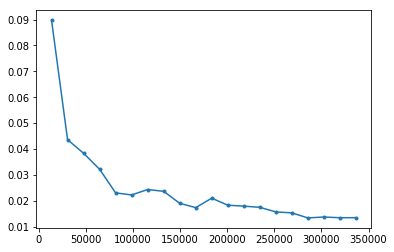

In [67]:
errors = []
x_axis = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    walk_length = 5*(ii + 1)
    walk_lengths.append(walk_length)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in random_walks_int:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1

    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors.append(np.abs(M_theory - M_empirical).max())
    x_axis.append(n_samples)

plt.plot(x_axis, errors, '.-')

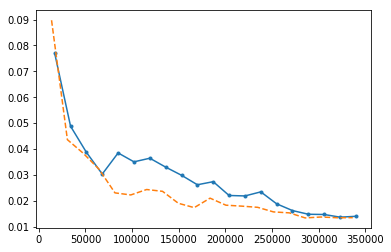

In [68]:
errors_nw = []
x_axis_nw = []
walk_length = random_walks_int.shape[1]
for ii in range(20):
    #walk_length = 5*(ii + 1)
    #walk_lengths.append(walk_length)
    
    num_walks = 5*(ii + 1)

    reduced_walks = []
    for kk in range(1, n_nodes+1):
        reduced_walks.append(
            random_walks_int[random_walks_int[:, 0] == kk][:num_walks]
        )
    reduced_walks = np.concatenate(reduced_walks)
    
    M_empirical = np.zeros((n_nodes, n_nodes))
    for walk in reduced_walks:
        for kk in range(walk_length - 1):
            M_empirical[walk[kk] - 1, walk[kk + 1] - 1] += 1
    n_samples = M_empirical.sum()
    M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1)

    errors_nw.append(np.abs(M_theory - M_empirical).max())
    x_axis_nw.append(n_samples)

plt.plot(x_axis_nw, errors_nw, '.-')
plt.plot(x_axis, errors, '--')

Theoretical transition probabilities

In [38]:
G = nx.karate_club_graph()

In [39]:
n_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G).toarray()
d_w = A.sum(axis=0)
M_theory = A.T / d_w

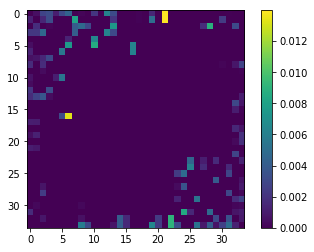

In [40]:
plt.imshow(np.abs(M_theory - M_empirical))
plt.colorbar()

In [47]:
error = np.abs(M_theory - M_empirical).max()
#error = np.linalg.norm(M_theory - M_empirical)
error

0.013974096796182667

Train word2vec embeddings using gensim

In [239]:
model = Word2Vec(random_walks_str, sg=1, size=20, window=5, sample=0, min_count=0, 
                 workers=4, seed=1321, iter=10, compute_loss=True)

In [240]:
model.get_latest_training_loss()

53827.1953125

Save embeddings

In [228]:
model.wv.save_word2vec_format("embeddings.out")

Extract embeddings as matrix of size `n_nodes` × `d`

In [241]:
V_w2v = model.wv.syn0
n_nodes, d_emb = V_w2v.shape

Node labels:

In [242]:
node_labels = np.zeros(n_nodes)
node_labels[:10] = 1

**Classification using single train/test split**

In [243]:
# Split using sklearn ShuffleSplit
ss = model_selection.ShuffleSplit(n_splits=1,
                                  train_size=0.6,
                                  test_size=0.4)
train_index, test_index = next(ss.split(V_w2v))

train_data = V_w2v[train_index]
test_data = V_w2v[test_index]
train_labels = node_labels[train_index]
test_labels  = node_labels[test_index]

# Classifier choice
#classifier = linear_model.LogisticRegression(C=10)
classifier = svm.SVC(C=1)

clf = make_pipeline(preprocessing.StandardScaler(), classifier)
clf.fit(train_data, train_labels)

train_pred = clf.predict(train_data)
test_pred = clf.predict(test_data)

print("Train acc:", clf.score(train_data, train_labels))
print("Test acc:", clf.score(test_data, test_labels))
print("Train f1:", f1_score(train_labels, train_pred, average='micro'))
print("Test f1:", f1_score(test_labels, test_pred, average='micro'))

Train acc: 0.85
Test acc: 0.642857142857
Train f1: 0.85
Test f1: 0.642857142857


**K-fold cross validation**

In [244]:
kf = model_selection.KFold(n_splits=4, shuffle=True)

acc_test_scores = []
f1_test_scores = []
for train_index, test_index in kf.split(V_w2v):
    train_data = V_w2v[train_index]
    test_data = V_w2v[test_index]
    train_labels = node_labels[train_index]
    test_labels  = node_labels[test_index]
    
    # Classifier choice
    #classifier = linear_model.LogisticRegression(C=10)
    classifier = svm.SVC(C=1)

    clf = make_pipeline(preprocessing.StandardScaler(), classifier)
    clf.fit(train_data, train_labels)

    train_pred = clf.predict(train_data)
    test_pred = clf.predict(test_data)

    acc_train = clf.score(train_data, train_labels)
    acc_test = clf.score(test_data, test_labels)
    f1_train = f1_score(train_labels, train_pred, average='micro')
    f1_test = f1_score(test_labels, test_pred, average='micro')
    
    acc_test_scores.append(acc_test)
    f1_test_scores.append(f1_test)
    
    print("Train acc={:4f},  Test acc={:4f},  Train f1={:4f},  Test f1={:4f}".format(
        acc_train, acc_test, f1_train, f1_test
    ))
    
print("Average scores:")
print("Avg test acc={:4f} [±{:2f}],  Avg test f1={:4f} [±{:2f}]".format(
    np.mean(acc_test_scores), np.std(acc_test_scores), 
    np.mean(f1_test_scores), np.std(f1_test_scores)
))

Train acc=0.800000,  Test acc=0.666667,  Train f1=0.800000,  Test f1=0.666667
Train acc=0.880000,  Test acc=0.666667,  Train f1=0.880000,  Test f1=0.666667
Train acc=0.769231,  Test acc=0.750000,  Train f1=0.769231,  Test f1=0.750000
Train acc=0.807692,  Test acc=0.750000,  Train f1=0.807692,  Test f1=0.750000
Average scores:
Avg test acc=0.708333 [±0.041667],  Avg test f1=0.708333 [±0.041667]
